# 0. Import Dependencies

In [40]:
import cv2
import numpy as np
import os
from matplotlib import pyplot
import time
import mediapipe as mp
import tensorflow as tf
import math
import itertools
import absl.logging

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix, accuracy_score, classification_report

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (LSTM, Dense, Dropout,Input, Flatten, Bidirectional, Permute, multiply)


from scipy import stats
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(1)
absl.logging.set_verbosity(absl.logging.ERROR)

# 1. USING MEDIA PIPE FOR DETECTION

In [41]:
def mp_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [42]:
pose_module = mp.solutions.pose
draw_lines = mp.solutions.drawing_utils

In [43]:
def draw_landmarks(image, results):
    draw_lines.draw_landmarks(image, results.pose_landmarks, pose_module.POSE_CONNECTIONS,
                                draw_lines.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                draw_lines.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

In [44]:
cap = cv2.VideoCapture(0) 
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
print(HEIGHT)
print(WIDTH)
FPS = 29
with pose_module.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()   
        image, results = mp_detection(frame, pose)
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
        draw_landmarks(image, results)               
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

720
1280


# 2. KEYPOINTS EXTRACTION FOR DATASET


In [45]:
pose = []
for i in results.pose_landmarks.landmark:
    test = np.array([i.x, i.y, i.z, i.visibility])
    pose.append(test)

In [46]:
# keypoints are 33 landmarks which will have 4 values (x, y, z, visibility)
num_landmarks = len(landmarks)
num_values = len(test)
num_input_values = num_landmarks*num_values
print(num_landmarks,num_values,num_input_values)

33 4 132


In [47]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

# 3. DATA COLLECTION 

In [48]:
#### RUN THIS WHEN USING PRE EXISTING DATA

DATA_PATH = os.path.join(os. getcwd(),'data') 
print(DATA_PATH)

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

actions = np.array(['curl','press','squat','butbrdige','leglift','situps'])
colors = [(245,117,16), (117,245,16),(16,117,245),(127, 0, 255),(255, 255, 0),(255,192,203)]
num_classes = len(actions)

no_sequences = 1
sequence_length = FPS*1
start_folder = 1

/Users/tsaiajay/Downloads/Project/data


In [49]:
######## DONT RUN THIS IF YOU RUN THE ABOVE CELL
###### used for dataset collection #######
#####  RUN THIS when NEED TO ADD NEW EXCERSICE OR NEW DAta


# DATA_PATH = os.path.join(os. getcwd(),'data') 
# print(DATA_PATH)
# if not os.path.exists(DATA_PATH):
#     os.makedirs(DATA_PATH)
# actions = np.array(['situps'])
# colors =[(255,192,203)]
# num_classes = len(actions)

# no_sequences = 30
# sequence_length = FPS*1
# start_folder = 160

In [11]:
#####DONT RUN IF YOU HAVE DATA EXISTS
###### used for dataset collection #######


######RUN IF YOU NEED TO GET MORE data

# for action in actions:     
#     for sequence in range(start_folder,no_sequences+start_folder):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))  
#         except:
#             pass

# 4. Collect Keypoint Values for Training and Testing

In [ ]:
##########DONT RUN IF YOU ALREADY HAVE DATA #############
###### used for dataset collection #######

# cap = cv2.VideoCapture(0)
# with pose_module.Pose(min_detection_confidence=0.6, min_tracking_confidence=0.6) as pose:
#     for idx, action in enumerate(actions):
#         for sequence in range(start_folder, start_folder+no_sequences):
#             for frame_num in range(sequence_length):
#                 ret, frame = cap.read()
#                 image, results = mp_detection(frame, pose)
#                 try:
#                     landmarks = results.pose_landmarks.landmark
#                 except:
#                     print("INTO EXCEPT")
#                     pass
                
#                 draw_landmarks(image, results) 
                
#                 if frame_num == 0: 
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                             cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
#                             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
#                             cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
#                     cv2.imshow('OpenCV Feed', image)
#                     cv2.waitKey(800)
#                 else: 
#                     cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
#                             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
#                             cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    
#                     cv2.imshow('OpenCV Feed', image)

#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
#                 np.save(npy_path, keypoints)
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break
                    
#     cap.release()
#     cv2.destroyAllWindows()

In [53]:
cap.release()
cv2.destroyAllWindows()

# 5. Preprocess Data and Create Labels/Features

In [50]:
label_map = {label:num for num, label in enumerate(actions)}

In [51]:
sequences, labels = [], []
for action in actions:
    for sequence in os.listdir(os.path.join(DATA_PATH, action)):
        if os.path.isdir(os.path.join(DATA_PATH, action, sequence)) and not sequence.startswith('.'):
            window = []
            for frame_num in range(sequence_length):
                i = np.load(os.path.join(DATA_PATH, action, sequence, "{}.npy".format(frame_num)))
                window.append(i)
                
            sequences.append(window)
            labels.append(label_map[action])

In [52]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(X.shape, y.shape)

(615, 29, 132) (615, 6)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print(X_train.shape, y_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, random_state=2)

(492, 29, 132) (492, 6)


# 6. Build and Train Neural Networks

In [54]:
e_cb = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10, verbose=0, mode='min')
l_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
check_cb = ModelCheckpoint(filepath=DATA_PATH, monitor='val_loss', verbose=0, save_best_only=True, 
                                 save_weights_only=False, mode='min', save_freq=1)

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

batch_size = 64
max_epochs = 500

## 6a. LSTM

In [55]:
NAME = f"ExerciseRecognition-LSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_cb = TensorBoard(log_dir=log_dir)

callbacks = [tb_cb, e_cb, l_cb, check_cb]

In [56]:
lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(sequence_length, num_input_values)))
lstm.add(LSTM(256, return_sequences=True, activation='relu'))
lstm.add(LSTM(128, return_sequences=False, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(actions.shape[0], activation='softmax'))
print(actions.shape[0])
print(lstm.summary())

6
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 29, 128)           133632    
                                                                 
 lstm_5 (LSTM)               (None, 29, 256)           394240    
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 6)                 390       
                                                                 
Total params: 750150 (2.86 MB)
Trainable params: 750

In [57]:
lstm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
lstm.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
7/7 [==============================] - 7s 281ms/step - loss: 21647300.0000 - categorical_accuracy: 0.1683 - val_loss: 5804.6831 - val_categorical_accuracy: 0.1707 - lr: 0.0100
Epoch 2/500
7/7 [==============================] - 1s 181ms/step - loss: 32916.4375 - categorical_accuracy: 0.2024 - val_loss: 110237.5000 - val_categorical_accuracy: 0.1829 - lr: 0.0100
Epoch 3/500
7/7 [==============================] - 1s 184ms/step - loss: 203234.3594 - categorical_accuracy: 0.2098 - val_loss: 573713.4375 - val_categorical_accuracy: 0.1341 - lr: 0.0100
Epoch 4/500
7/7 [==============================] - 1s 183ms/step - loss: 187621.5625 - categorical_accuracy: 0.1049 - val_loss: 19193.8359 - val_categorical_accuracy: 0.2073 - lr: 0.0100
Epoch 5/500
7/7 [==============================] - 1s 204ms/step - loss: 9657.7314 - categorical_accuracy: 0.1805 - val_loss: 2127.9058 - val_categorical_accuracy: 0.1585 - lr: 0.0100
Epoch 6/500
7/7 [==============================] - 1s 184ms/step -

## 6b. LSTM + Attention

In [58]:
NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_cb = TensorBoard(log_dir=log_dir)
callbacks = [tb_cb, e_cb, l_cb, check_cb]

In [59]:
def attention_block(inputs, time_steps):
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Luong's multiplicative score
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul') 
    return output_attention_mul

In [60]:
H_units = 256
input = Input(shape=(sequence_length, num_input_values))
bi_lstm = Bidirectional(LSTM(H_units, return_sequences=True))(input)
attention_layer = attention_block(bi_lstm, sequence_length)
flattend_attention = Flatten()(attention_layer)
dense_1 = Dense(2*H_units, activation='relu')(flattend_attention)
dropout = Dropout(0.5)(dense_1)
x = Dense(actions.shape[0], activation='softmax')(dropout)

AttnLSTM = Model(inputs=[input], outputs=x)
print(AttnLSTM.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 29, 132)]            0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 29, 512)              796672    ['input_2[0][0]']             
 onal)                                                                                            
                                                                                                  
 permute_1 (Permute)         (None, 512, 29)              0         ['bidirectional_1[0][0]']     
                                                                                                  
 dense_9 (Dense)             (None, 512, 29)              870       ['permute_1[0][0]']     

In [61]:
AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
AttnLSTM.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500


7/7 [==============================] - 8s 447ms/step - loss: 1.9884 - categorical_accuracy: 0.3146 - val_loss: 1.3768 - val_categorical_accuracy: 0.4268 - lr: 0.0020
Epoch 2/500
7/7 [==============================] - 2s 282ms/step - loss: 1.0812 - categorical_accuracy: 0.5634 - val_loss: 1.2318 - val_categorical_accuracy: 0.6951 - lr: 0.0020
Epoch 3/500
7/7 [==============================] - 2s 362ms/step - loss: 0.8290 - categorical_accuracy: 0.6829 - val_loss: 0.5880 - val_categorical_accuracy: 0.7927 - lr: 0.0020
Epoch 4/500
7/7 [==============================] - 3s 391ms/step - loss: 0.4534 - categorical_accuracy: 0.8341 - val_loss: 0.4371 - val_categorical_accuracy: 0.8780 - lr: 0.0020
Epoch 5/500
7/7 [==============================] - 3s 364ms/step - loss: 0.3597 - categorical_accuracy: 0.8732 - val_loss: 0.4847 - val_categorical_accuracy: 0.8049 - lr: 0.0020
Epoch 6/500
7/7 [==============================] - 3s 387ms/step - loss: 0.3670 - categorical_accuracy: 0.8488 - val_loss:

In [62]:
# Model map
models = {
    'LSTM_new': lstm, 
    'LSTM_Attention_new': AttnLSTM, 
}

# 7a. Save Weights

In [63]:
for model_name, model in models.items():
    save_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.save(save_dir)

/Users/tsaiajay/anaconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 7b. Load Weights

In [64]:
for model_name, model in models.items():
    load_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.load_weights(load_dir)

# 8. Make Predictions

In [65]:
for model in models.values():
    i = model.predict(X_test, verbose=0)   

# 9. Evaluations using Confusion Matrix and Accuracy

In [66]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}   
precisions = {}
recalls = {}
f1_scores = {} 

In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):

    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

## 9a. Confusion Matrices

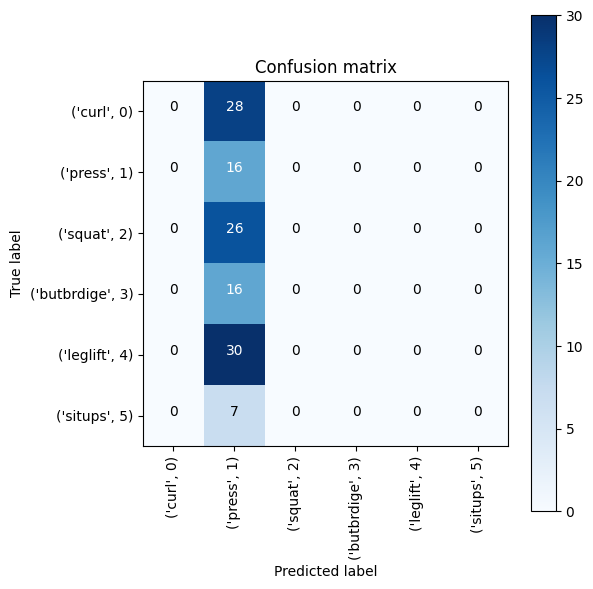

LSTM_new confusion matrix: 
[[ 0 28  0  0  0  0]
 [ 0 16  0  0  0  0]
 [ 0 26  0  0  0  0]
 [ 0 16  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  7  0  0  0  0]]


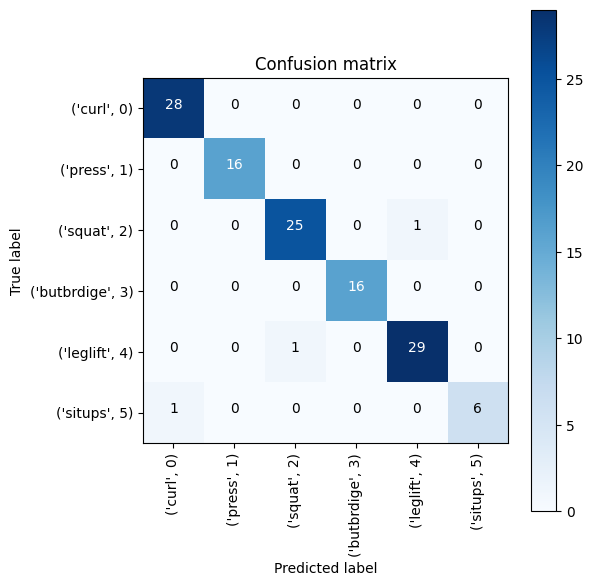

LSTM_Attention_new confusion matrix: 
[[28  0  0  0  0  0]
 [ 0 16  0  0  0  0]
 [ 0  0 25  0  1  0]
 [ 0  0  0 16  0  0]
 [ 0  0  1  0 29  0]
 [ 1  0  0  0  0  6]]


In [68]:
for model_name, model in models.items():
    
    yhat = model.predict(X_test, verbose=0)
    
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    confusion_matrices[model_name] = confusion_matrix(ytrue, yhat)
    confusion_mtx  = confusion_matrix(ytrue, yhat)
    cm = plot_confusion_matrix(confusion_mtx, classes = list(label_map.items()), normalize=False)
    print(f"{model_name} confusion matrix: {os.linesep}{confusion_matrices[model_name]}")
eval_results['confusion matrix'] = confusion_matrices

## 9b. Accuracy

In [69]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)   
     
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")

eval_results['accuracy'] = classification_accuracies

LSTM_new classification accuracy = 13.008%
LSTM_Attention_new classification accuracy = 97.561%


## 9c. Precision, Recall, and F1 Score

In [70]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    report = classification_report(ytrue, yhat, target_names=actions, output_dict=True)
    
    precisions[model_name] = report['weighted avg']['precision']
    recalls[model_name] = report['weighted avg']['recall']
    f1_scores[model_name] = report['weighted avg']['f1-score'] 

    print("Classification Report:\n", classification_report(ytrue, yhat))
   
eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores

/Users/tsaiajay/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tsaiajay/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tsaiajay/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.13      1.00      0.23        16
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00         7

    accuracy                           0.13       123
   macro avg       0.02      0.17      0.04       123
weighted avg       0.02      0.13      0.03       123

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      1.00      1.00        16
           2       0.96      0.96      0.96        26
           3       1.00      1.00      1.00        16
           4       0.97      0.97      0.97        30
           5       1.00      0.86      0.92         7

    accuracy                 

# 10. Choose Model to Test in Real Time

In [71]:
model = AttnLSTM
model_name = 'AttnLSTM'

# 11. Calculate Joint Angles & Count Reps

In [72]:
def angle_calculation(a,b,c):
    a = np.array(a) 
    b = np.array(b)
    c = np.array(c)
    
    rad = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(rad*180.0/np.pi)
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [73]:
def co_ordinates(landmarks, mp_pose, side, joint):
    coord = getattr(mp_pose.PoseLandmark,side.upper()+"_"+joint.upper())
    x_val = landmarks[coord.value].x
    y_val = landmarks[coord.value].y
    return [x_val, y_val]            

In [74]:
def show_angle(image, angle, joint):
    cv2.putText(image, str(int(angle)), 
                   tuple(np.multiply(joint, [640, 480]).astype(int)), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                        )
    return

In [78]:
def count_reps(image, current_action, landmarks, mp_pose):
    global curl_stage, press_stage, squat_stage, butbrdige_stage, leglift_stage,r_leglift_stage,l_butbrdige_stage,situps_stage,curl_counter, press_counter, squat_counter,butbrdige_counter,leglift_counter,situps_counter

    if current_action == 'situps':
        shoulder_l = co_ordinates(landmarks, mp_pose, 'left', 'shoulder')
        hip_l = co_ordinates(landmarks, mp_pose, 'left', 'hip')
        knee_l = co_ordinates(landmarks, mp_pose, 'left', 'knee')
    
        shoulder_r = co_ordinates(landmarks, mp_pose, 'right', 'shoulder')
        hip_r = co_ordinates(landmarks, mp_pose, 'right', 'hip')
        knee_r = co_ordinates(landmarks, mp_pose, 'right', 'knee')
    
        angle_left = angle_calculation(shoulder_l, hip_l, knee_l)
        angle_right = angle_calculation(shoulder_r, hip_r, knee_r)
    
        # if angle_left > 160:
        #     l_situps_stage = "up"
        #     print(l_situps_stage, "Left")
        # if angle_left < 140 and l_situps_stage == "up":
        #     print("Sit-ups counted for left side")
        #     l_situps_stage = "down"
    
        if angle_right <100 :
            situps_stage = "up"
        if angle_right > 120 and situps_stage == "up":
            situps_stage = "down"
            situps_counter+=1
    
        press_stage = None
        squat_stage = None
        curl_stage = None
        leglift_stage = None
        r_leglift_stage = None
        butbrdige_stage=None
        l_butbrdige_stage =None
        

        show_angle(image, angle_right, hip_r)

    elif current_action == 'butbrdige':
        shoulder_l = co_ordinates(landmarks, mp_pose, 'left', 'shoulder')
        hip_l = co_ordinates(landmarks, mp_pose, 'left', 'hip')
        knee_l = co_ordinates(landmarks, mp_pose, 'left', 'knee')

        shoulder_r = co_ordinates(landmarks, mp_pose, 'right', 'shoulder')
        hip_r = co_ordinates(landmarks, mp_pose, 'right', 'hip')
        knee_r = co_ordinates(landmarks, mp_pose, 'right', 'knee')

        angle_left = angle_calculation(shoulder_l,hip_l,knee_l)
        angle_right = angle_calculation(knee_r,hip_r,shoulder_r)
        
        # if (angle_right <180 and angle_right > 170):
        #     butbrdige_stage="up"
        #     print(butbrdige_stage,"right")
        # if (angle_right <160 and butbrdige_stage=="up"):
        #     print("ddddddd_right",butbrdige_stage)
        #     butbrdige_stage="down"
        #     butbrdige_counter+=1

        if(angle_left <180 and angle_left > 170) :
            l_butbrdige_stage="up"
        if(angle_left <160 and l_butbrdige_stage=="up"):
            l_butbrdige_stage="down"
            butbrdige_counter+=1

        press_stage = None
        squat_stage = None
        curl_stage=None
        leglift_stage=None
        r_leglift_stage=None

        show_angle(image, angle_right, hip_r)

    elif current_action == 'leglift':

        shoulder_l = co_ordinates(landmarks, mp_pose, 'left', 'shoulder')
        hip_l = co_ordinates(landmarks, mp_pose, 'left', 'hip')
        knee_l = co_ordinates(landmarks, mp_pose, 'left', 'knee')
        ankle_l = co_ordinates(landmarks, mp_pose, 'left', 'ankle')

        shoulder_r = co_ordinates(landmarks, mp_pose, 'right', 'shoulder')
        hip_r = co_ordinates(landmarks, mp_pose, 'right', 'hip')
        knee_r = co_ordinates(landmarks, mp_pose, 'right', 'knee')
        ankle_r = co_ordinates(landmarks, mp_pose, 'right', 'ankle')

        hip_angle_left = angle_calculation(shoulder_l,hip_l,knee_l)
        hip_angle_right = angle_calculation(shoulder_r,hip_r,knee_r)

        knee_angle_left = angle_calculation(hip_l,knee_l,ankle_l)
        knee_angle_right = angle_calculation(hip_r,knee_r,ankle_r)
        
        d_hip_angle_left = angle_calculation(shoulder_l,hip_l,ankle_l)
        d_hip_angle_right = angle_calculation(shoulder_r,hip_r,ankle_r)
       

        if (hip_angle_left<100 and hip_angle_left > 70) and (knee_angle_left> 40 and knee_angle_left < 90):
            leglift_stage = "up" 
            
        if d_hip_angle_left>170 and leglift_stage == "up" :
            leglift_stage="down"
            leglift_counter +=1

        if (hip_angle_right<100 and hip_angle_right > 70) and (knee_angle_right> 40 and knee_angle_right < 90):
            r_leglift_stage = "up" 
    
        if d_hip_angle_right>170 and r_leglift_stage == "up" :
            r_leglift_stage="down"
            leglift_counter +=1

        butbrdige_stage=None
        press_stage = None
        squat_stage = None
        curl_stage = None
        l_butbrdige_stage =None
    
    elif current_action == 'curl':
        shoulder_l = co_ordinates(landmarks, mp_pose, 'left', 'shoulder')
        elbow_l = co_ordinates(landmarks, mp_pose, 'left', 'elbow')
        wrist_l = co_ordinates(landmarks, mp_pose, 'left', 'wrist')

        shoulder_r = co_ordinates(landmarks, mp_pose, 'right', 'shoulder')
        elbow_r = co_ordinates(landmarks, mp_pose, 'right', 'elbow')
        wrist_r = co_ordinates(landmarks, mp_pose, 'right', 'wrist')
        
        elbow_angle_l = angle_calculation(shoulder_l, elbow_l, wrist_l)
        elbow_angle_r = angle_calculation(shoulder_r, elbow_r, wrist_r)
        
        if elbow_angle_l < 30 and elbow_angle_r<30:
            curl_stage = "up" 
        if elbow_angle_l > 160 and elbow_angle_r>160 and curl_stage =='up':
            curl_stage="down"  
            curl_counter +=1

        butbrdige_stage=None
        press_stage = None
        squat_stage = None
        leglift_stage=None
        r_leglift_stage=None
        l_butbrdige_stage =None
        show_angle(image, elbow_angle_l, elbow_l)
        show_angle(image, elbow_angle_r, elbow_r)
        
    elif current_action == 'press':
        
        shoulder_l = co_ordinates(landmarks, mp_pose, 'left', 'shoulder')
        elbow_l = co_ordinates(landmarks, mp_pose, 'left', 'elbow')
        wrist_l = co_ordinates(landmarks, mp_pose, 'left', 'wrist')

        shoulder_r = co_ordinates(landmarks, mp_pose, 'right', 'shoulder')
        elbow_r = co_ordinates(landmarks, mp_pose, 'right', 'elbow')
        wrist_r = co_ordinates(landmarks, mp_pose, 'right', 'wrist')

        elbow_angle_l = angle_calculation(shoulder_l, elbow_l, wrist_l)
        elbow_angle_r = angle_calculation(shoulder_r, elbow_r, wrist_r)
        
        if (elbow_angle_l > 140) and (elbow_angle_r > 140) :
            press_stage = "up"
        if (elbow_angle_l< 50 and press_stage =='up') and (elbow_angle_r< 50 and press_stage =='up'):
            press_stage='down'
            press_counter += 1
        butbrdige_stage=None
        curl_stage = None
        squat_stage = None
        leglift_stage=None
        r_leglift_stage=None
        l_butbrdige_stage =None
            
        show_angle(image, elbow_angle_l, elbow_l)
        show_angle(image, elbow_angle_r, elbow_r)
        
    elif current_action == 'squat':
        
        left_shoulder = co_ordinates(landmarks, mp_pose, 'left', 'shoulder')
        left_hip = co_ordinates(landmarks, mp_pose, 'left', 'hip')
        left_knee = co_ordinates(landmarks, mp_pose, 'left', 'knee')
        left_ankle = co_ordinates(landmarks, mp_pose, 'left', 'ankle')
        right_shoulder = co_ordinates(landmarks, mp_pose, 'right', 'shoulder')
        right_hip = co_ordinates(landmarks, mp_pose, 'right', 'hip')
        right_knee = co_ordinates(landmarks, mp_pose, 'right', 'knee')
        right_ankle = co_ordinates(landmarks, mp_pose, 'right', 'ankle')
        
        left_knee_angle = angle_calculation(left_hip, left_knee, left_ankle)
        right_knee_angle = angle_calculation(right_hip, right_knee, right_ankle)
        
        left_hip_angle = angle_calculation(left_shoulder, left_hip, left_knee)
        right_hip_angle = angle_calculation(right_shoulder, right_hip, right_knee)
        
        thr = 165
        if (left_knee_angle < thr) and (right_knee_angle < thr) and (left_hip_angle < thr) and (right_hip_angle < thr):
            squat_stage = "down"
        if (left_knee_angle > thr) and (right_knee_angle > thr) and (left_hip_angle > thr) and (right_hip_angle > thr) and (squat_stage =='down'):
            squat_stage='up'
            squat_counter += 1
            
        butbrdige_stage=None
        curl_stage = None
        press_stage = None
        leglift_stage=None
        r_leglift_stage=None
        l_butbrdige_stage =None
            
        show_angle(image, left_knee_angle, left_knee)
        show_angle(image, left_hip_angle, left_hip)
        
    else:
        pass

# 12. Test in Real Time

In [76]:
def probability(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):        
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
        
    return output_frame

In [79]:
sequence = []
predictions = []
i = []
threshold = 0.5 
current_action = ''

curl_counter = 0
press_counter = 0
squat_counter = 0
butbrdige_counter=0
leglift_counter=0
situps_counter=0

curl_stage = None
press_stage = None
squat_stage = None
butbrdige_stage= None
leglift_stage=None
l_butbrdige_stage=None
situps_stage=None

cap = cv2.VideoCapture(0)

fourcc = cv2.VideoWriter_fourcc('M','J','P','G') 
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
FPS = int(cap.get(cv2.CAP_PROP_FPS))

video_name = os.path.join(os.getcwd(),f"{model_name}_real_time_test.avi")
out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), FPS, (WIDTH,HEIGHT))

with pose_module.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mp_detection(frame, pose)
        draw_landmarks(image, results)
        keypoints = extract_keypoints(results)        
        sequence.append(keypoints)      
        sequence = sequence[-sequence_length:]
              
        if len(sequence) == sequence_length:
            i = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]           
            predictions.append(np.argmax(i))
            current_action = actions[np.argmax(i)]
            confidence = np.max(i)
            
            if confidence < threshold:
                current_action = ''
            image = probability(i, actions, image, colors)
            
            try:
                landmarks = results.pose_landmarks.landmark
                count_reps(
                    image, current_action, landmarks, pose_module)
            except:
                pass

            cv2.rectangle(image, (0,0), (1400, 40), colors[np.argmax(i)], -1)
            cv2.putText(image, 'curl ' + str(curl_counter), (5,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(image, 'press ' + str(press_counter), (225,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(image, 'squat ' + str(squat_counter), (450,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(image, 'butbrdige ' + str(butbrdige_counter), (625,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(image, 'leglift ' + str(leglift_counter), (825,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(image, 'situps ' + str(situps_counter), (1020,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
            
             
        cv2.imshow('OpenCV Feed', image)       
        if ret == True:
            out.write(image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
out.release()
cv2.destroyAllWindows()